In [ ]:
!pip install wandb -qU
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import the necessary packages
import logging
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
wandb.login()

True

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

In [ ]:
class LeNet:
  ''' 
  # create LeNet-5 model
  #
  # it is composed of the 8 layers (5 layers considering FC as one layer) 
  # such as:
  #      - 2 convolutional layers
  #      - 2 subsampling (avg pooling) layers
  #      - 1 flatten layer
  #      - 2 fully connected layers
  #      - 1 output layer with 10 outputs
  '''
  @staticmethod
  def build(width, height, depth, classes,config):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(6, (5,5), strides=1, padding='same',
                     activation=config.activation, input_shape=(28,28,1), )) #C1
    if(config.batch_normalization[0]==1):
      model.add(BatchNormalization())
    model.add(AveragePooling2D()) #S2
    model.add(Dropout(config.drop1))

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(16, (5,5), strides=1, padding='valid',
                     activation=config.activation)) #C3
    if(config.batch_normalization[1]==1):
       model.add(BatchNormalization())

    model.add(AveragePooling2D()) #S4
    model.add(Dropout(config.drop2))
    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation=config.activation)) #C5
    model.add(Dropout(config.drop3))
    model.add(Dense(84, activation=config.activation)) #F6
    model.add(Dropout(config.drop4))

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [ ]:
args = {
  "project_name": "lenet-modificada2"
}

In [ ]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 11MB download may take a second)
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

22-10-2022 13:36:36 [INFO] accessing MNIST...
22-10-2022 13:36:37 Train x: (60000, 28, 28)
22-10-2022 13:36:37 Train y: (60000,)
22-10-2022 13:36:37 Test x: (10000, 28, 28)
22-10-2022 13:36:37 Test y: (10000,)


In [ ]:
# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	train_x = train_x.reshape((train_x.shape[0], 1, 28, 28))
	test_x = test_x.reshape((test_x.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
	test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [ ]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

22-10-2022 13:36:41 Train x: (60000, 28, 28, 1)
22-10-2022 13:36:41 Train y: (60000,)
22-10-2022 13:36:41 Test x: (10000, 28, 28, 1)
22-10-2022 13:36:41 Test y: (10000,)


In [ ]:
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

In [ ]:
qtd =1

In [1]:
sweep_config = {
    'method': 'random'
    }
metric ={
      'name': 'val_accuracy',
      'goal': 'maximize'   
    }
sweep_config['metric'] = metric
parameters_dict = {
    'activation':
    {
        'values' : ['tanh','relu']   
    },
    'batch_normalization':
    {
         'values' : [(0,0), (0,1), (1,1), (1,0)] 
    },
    'drop1':
    {
        'values' : [0, 0.10, 0.15, 0.20, 0.25] 
    },
    'drop2':
    {
        'values' : [0, 0.10, 0.15, 0.20, 0.25] 
    },
    'drop3':
    {
        'values' : [0, 0.25, 0.40, 0.50] 
    },
    'drop4':
    {
        'values' : [0, 0.25, 0.40, 0.50] 
    },
    }
sweep_config['parameters'] = parameters_dict



In [2]:
sweep_config

{'method': 'random',
 'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
 'parameters': {'activation': {'values': ['tanh', 'relu']},
  'batch_normalization': {'values': [(0, 0), (0, 1), (1, 1), (1, 0)]},
  'drop1': {'values': [0, 0.1, 0.15, 0.2, 0.25]},
  'drop2': {'values': [0, 0.1, 0.15, 0.2, 0.25]},
  'drop3': {'values': [0, 0.25, 0.4, 0.5]},
  'drop4': {'values': [0, 0.25, 0.4, 0.5]}}}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=args['project_name'])

Create sweep with ID: 06rgwsf7
Sweep URL: https://wandb.ai/igordias/lenet-modificada2/sweeps/06rgwsf7


In [ ]:
def treino(config=None):
  global qtd
  with wandb.init(entity="igordias",project=args["project_name"], job_type="Train") as run:

    wandb.run.name = 'treino' + str(qtd)
    qtd+=1

    config = wandb.config
    model = LeNet.build(28,28,1,10,config)

    # summarize layers
    model.summary()
    # create codecarbon tracker
    # codecarbon is too much verbose, change the log level for more info
    tracker = EmissionsTracker(log_level="critical")
    tracker.start()

    # initialize the optimizer and model
    logger.info("[INFO] compiling model...")
    opt = Adam(learning_rate=0.01)
    model = LeNet.build(width=28, height=28, depth=1, classes=10,config=config)
    model.compile(loss="categorical_crossentropy", optimizer=opt,
                  metrics=["accuracy"])

    # train the network
    logger.info("[INFO] training network...")
    history = model.fit(train_x, train_y,
                  validation_data=(test_x, test_y),
                  batch_size=32,
                  epochs=20, 
                  verbose=0,
                  callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                      compute_flops=True)])

    # get co2 emissions from tracker
    # "CO2 emission (in Kg)"
    emissions = tracker.stop()
    # plot the training loss and accuracy
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,1,figsize=(10,8))

    ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
    ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
    ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
    ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
    ax.set_title("Training Loss and Accuracy")
    ax.set_xlabel("Epoch #")
    ax.set_ylabel("Loss/Accuracy")
    ax.legend()
    plt.show()
    print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
    print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
    print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
    print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
    print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))
    # evaluate the network
    print("[INFO] evaluating network...")
    predictions = model.predict(test_x, batch_size=32)
    print(classification_report(test_y.argmax(axis=1),
                                predictions.argmax(axis=1),
                                target_names=[str(i) for i in lb.classes_]))
    fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
    ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                            test_y.argmax(axis=1)),
                          display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

    ax.set_xlabel("True Label")
    ax.set_ylabel("Predicted Label")
    ax.grid(False)
    plt.show()
    # Uploading figures
    logger.info("Uploading figures")
    run.log(
        {
            "confusion_matrix": wandb.Image(fig_confusion_matrix),
            # "other_figure": wandb.Image(other_fig)
        }
    )
    # Evaluation Metrics
    logger.info("Validation Evaluation metrics")
    fbeta = fbeta_score(test_y.argmax(axis=1), 
                        predictions.argmax(axis=1), 
                        beta=1, zero_division=1,average='weighted')
    precision = precision_score(test_y.argmax(axis=1),
                                predictions.argmax(axis=1),
                                zero_division=1,average='weighted')
    recall = recall_score(test_y.argmax(axis=1),
                          predictions.argmax(axis=1),
                          zero_division=1,average='weighted')
    acc = accuracy_score(test_y.argmax(axis=1),
                        predictions.argmax(axis=1))

    logger.info("Validation Accuracy: {}".format(acc))
    logger.info("Validation Precision: {}".format(precision))
    logger.info("Validation Recall: {}".format(recall))
    logger.info("Validation F1: {}".format(fbeta))

    run.summary["Acc"] = acc
    run.summary["Precision"] = precision
    run.summary["Recall"] = recall
    run.summary["F1"] = fbeta
    # number of parameters
    run.summary["Count_Params"] = model.count_params()
    # energy unit is kWh
    run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
    run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
    run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
    run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
    # kg
    run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions


wandb: Agent Starting Run: zgy6qq1b with config:
wandb: 	activation: relu
wandb: 	batch_normalization: [1, 0]
wandb: 	drop1: 0.25
wandb: 	drop2: 0
wandb: 	drop3: 0.5
wandb: 	drop4: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        24        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0

22-10-2022 13:37:11 [INFO] compiling model...
22-10-2022 13:37:11 [INFO] training network...


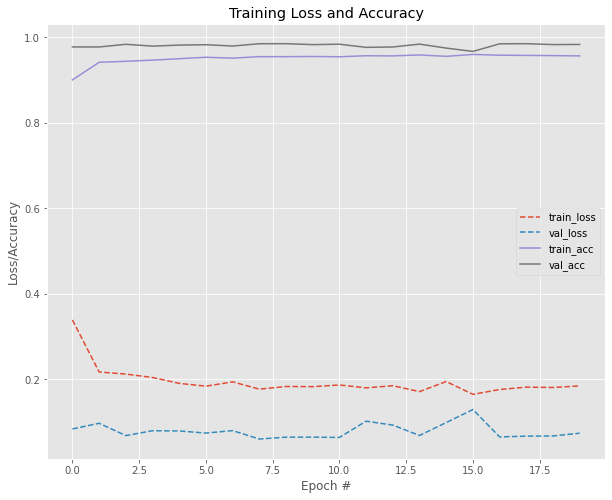

[INFO] 0.002870239034728409 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00016389508423798806 kWh
[INFO] Energy consumed for all GPU: 0.0012406375543875165 kWh
[INFO] Energy consumed for all CPU: 0.0014657063961029055 kWh
[INFO] CO2 emission 0.0009127360130436341(in Kg)
[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.98      0.99      1032
           3       1.00      0.98      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.97      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.96      0.97      0.97      1009

    accuracy     

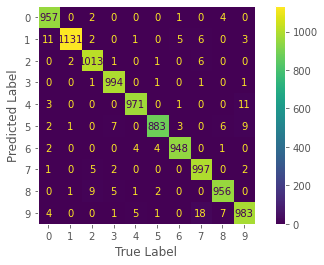

22-10-2022 13:39:17 Uploading figures
22-10-2022 13:39:17 Validation Evaluation metrics
22-10-2022 13:39:17 Validation Accuracy: 0.9833
22-10-2022 13:39:17 Validation Precision: 0.9834128598058777
22-10-2022 13:39:17 Validation Recall: 0.9833
22-10-2022 13:39:17 Validation F1: 0.9833088836781593


accuracy,▁▆▆▆▇▇▇▇▇▇▇███▇█████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▃▂▂▂▁▂▂▂▂▂▁▂▁▁▂▂▂
val_accuracy,▅▅▇▆▇▇▆██▇█▅▅█▄▁██▇▇
val_loss,▃▅▂▃▃▂▃▁▁▁▁▅▄▂▅█▂▂▂▂
Acc,0.9833
CO2_Emissions,0.00091
Count_Params,61730
Energy_CPU,0.00147
Energy_Consumed,0.00287
Energy_GPU,0.00124


wandb: Agent Starting Run: aswl20fi with config:
wandb: 	activation: relu
wandb: 	batch_normalization: [1, 1]
wandb: 	drop1: 0.25
wandb: 	drop2: 0.15
wandb: 	drop3: 0
wandb: 	drop4: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        24        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 16)       6

22-10-2022 13:39:31 [INFO] compiling model...
22-10-2022 13:39:31 [INFO] training network...


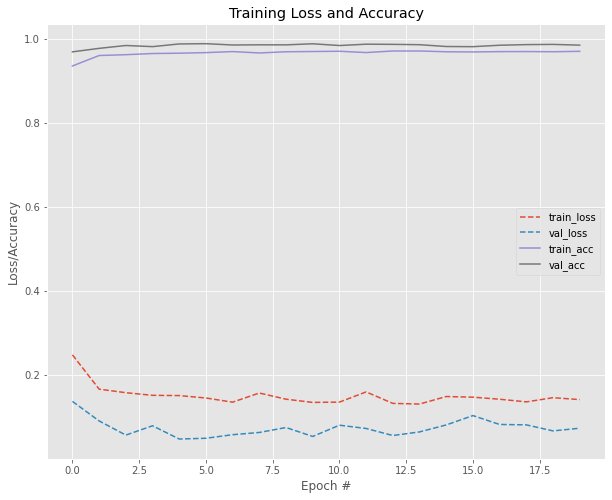

[INFO] 0.003295362711027103 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00018857160179492857 kWh
[INFO] Energy consumed for all GPU: 0.001420447188007898 kWh
[INFO] Energy consumed for all CPU: 0.0016863439212242764 kWh
[INFO] CO2 emission 0.0010479253421066188(in Kg)
[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       1.00      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.96      0.99      0.98      1028
           8       0.95      0.99      0.97       974
           9       0.99      0.95      0.97      1009

    accuracy      

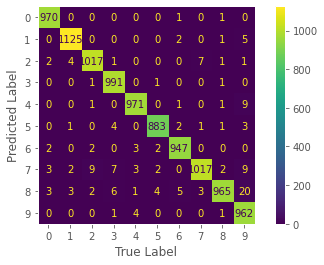

22-10-2022 13:41:55 Uploading figures
22-10-2022 13:41:55 Validation Evaluation metrics
22-10-2022 13:41:56 Validation Accuracy: 0.9848
22-10-2022 13:41:56 Validation Precision: 0.9850393622338315
22-10-2022 13:41:56 Validation Recall: 0.9848
22-10-2022 13:41:56 Validation F1: 0.9848186077446631


accuracy,▁▆▆▇▇▇█▇███▇████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▂▂▂▁▃▂▁▁▃▁▁▂▂▂▁▂▂
val_accuracy,▁▄▆▅██▇▇▇█▆█▇▇▆▅▇▇▇▇
val_loss,█▄▂▃▁▁▂▂▃▁▄▃▂▂▄▅▄▄▃▃
Acc,0.9848
CO2_Emissions,0.00105
Count_Params,61794
Energy_CPU,0.00169
Energy_Consumed,0.0033
Energy_GPU,0.00142


wandb: Agent Starting Run: xxwg7s75 with config:
wandb: 	activation: relu
wandb: 	batch_normalization: [0, 0]
wandb: 	drop1: 0.15
wandb: 	drop2: 0
wandb: 	drop3: 0
wandb: 	drop4: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 16)          0

22-10-2022 13:42:13 [INFO] compiling model...
22-10-2022 13:42:13 [INFO] training network...


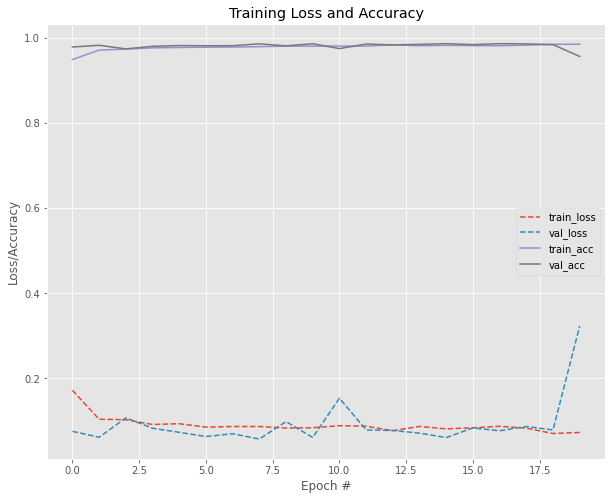

[INFO] 0.003274795402529451 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00018836755363538333 kWh
[INFO] Energy consumed for all GPU: 0.0014019749567164316 kWh
[INFO] Energy consumed for all CPU: 0.0016844528921776346 kWh
[INFO] CO2 emission 0.0010413849380043654(in Kg)
[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.94      0.96      1010
           4       0.96      0.98      0.97       982
           5       0.97      0.95      0.96       892
           6       0.89      0.99      0.94       958
           7       0.91      0.99      0.95      1028
           8       0.99      0.87      0.92       974
           9       0.93      0.96      0.95      1009

    accuracy     

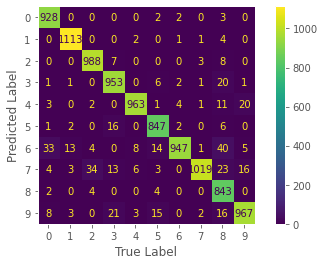

22-10-2022 13:44:37 Uploading figures
22-10-2022 13:44:37 Validation Evaluation metrics
22-10-2022 13:44:37 Validation Accuracy: 0.9568
22-10-2022 13:44:37 Validation Precision: 0.9587298105461208
22-10-2022 13:44:37 Validation Recall: 0.9568
22-10-2022 13:44:37 Validation F1: 0.9568090498634034


accuracy,▁▅▆▆▆▇▇▇▇▇▇▇█▇▇▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▂▃▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁
val_accuracy,▆▇▅▇▇▇▇█▇█▅█▇██▇██▇▁
val_loss,▁▁▂▂▁▁▁▁▂▁▄▂▂▁▁▂▂▂▂█
Acc,0.9568
CO2_Emissions,0.00104
Count_Params,61706
Energy_CPU,0.00168
Energy_Consumed,0.00327
Energy_GPU,0.0014


wandb: Agent Starting Run: qw6yciw8 with config:
wandb: 	activation: relu
wandb: 	batch_normalization: [1, 0]
wandb: 	drop1: 0
wandb: 	drop2: 0.2
wandb: 	drop3: 0.5
wandb: 	drop4: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        24        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0

22-10-2022 13:44:54 [INFO] compiling model...
22-10-2022 13:44:54 [INFO] training network...


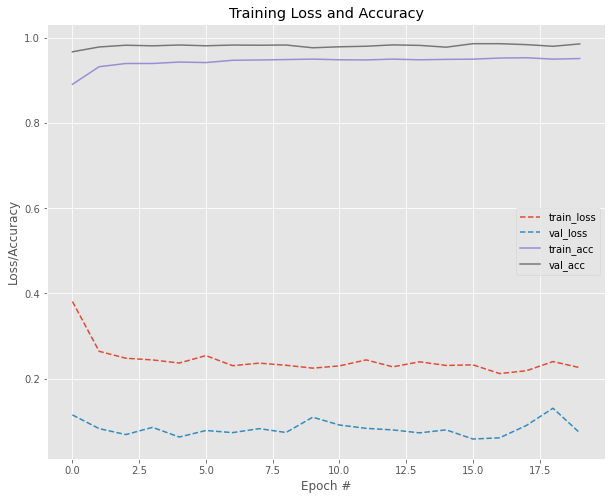

[INFO] 0.002870016840621544 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00016810056463954887 kWh
[INFO] Energy consumed for all GPU: 0.0011986839942441385 kWh
[INFO] Energy consumed for all CPU: 0.0015032322817378576 kWh
[INFO] CO2 emission 0.0009126653553176511(in Kg)
[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.98      1032
           3       1.00      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.97      0.98      1028
           8       0.96      0.98      0.97       974
           9       0.99      0.98      0.98      1009

    accuracy     

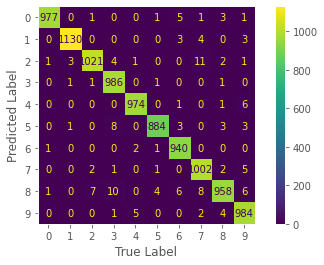

22-10-2022 13:47:02 Uploading figures
22-10-2022 13:47:02 Validation Evaluation metrics
22-10-2022 13:47:03 Validation Accuracy: 0.9856
22-10-2022 13:47:03 Validation Precision: 0.9857249346071704
22-10-2022 13:47:03 Validation Recall: 0.9856
22-10-2022 13:47:03 Validation F1: 0.9856126579803054


accuracy,▁▆▆▆▇▇▇▇██▇▇█▇██████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂
val_accuracy,▁▅▇▆▇▆▇▇▇▄▅▆▇▇▅██▇▆█
val_loss,▆▃▂▄▁▃▂▃▂▆▄▃▃▂▃▁▁▄█▂
Acc,0.9856
CO2_Emissions,0.00091
Count_Params,61730
Energy_CPU,0.0015
Energy_Consumed,0.00287
Energy_GPU,0.0012


wandb: Agent Starting Run: fkn28ie1 with config:
wandb: 	activation: tanh
wandb: 	batch_normalization: [1, 0]
wandb: 	drop1: 0.25
wandb: 	drop2: 0.25
wandb: 	drop3: 0.25
wandb: 	drop4: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        24        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0

22-10-2022 13:47:19 [INFO] compiling model...
22-10-2022 13:47:19 [INFO] training network...


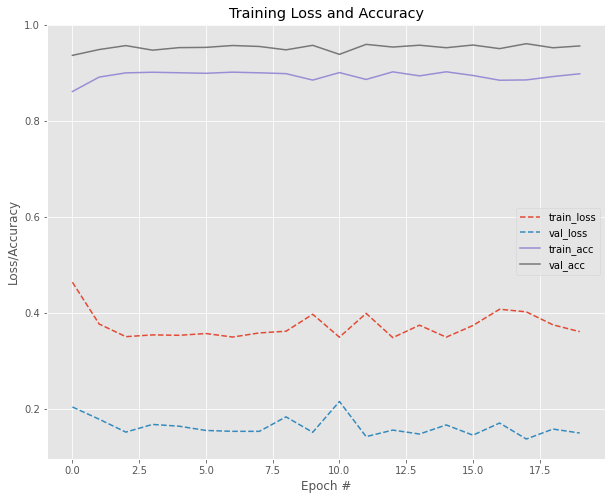

[INFO] 0.00326774633828573 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00018855979998740104 kWh
[INFO] Energy consumed for all GPU: 0.0013929489072224165 kWh
[INFO] Energy consumed for all CPU: 0.0016862376310759122 kWh
[INFO] CO2 emission 0.0010391433355748621(in Kg)
[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.96      0.92      0.94      1032
           3       0.97      0.94      0.95      1010
           4       0.97      0.95      0.96       982
           5       0.96      0.97      0.97       892
           6       0.96      0.98      0.97       958
           7       0.93      0.96      0.95      1028
           8       0.92      0.95      0.93       974
           9       0.94      0.92      0.93      1009

    accuracy      

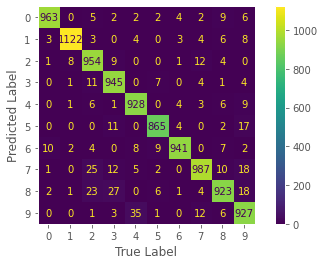

22-10-2022 13:49:44 Uploading figures
22-10-2022 13:49:44 Validation Evaluation metrics
22-10-2022 13:49:44 Validation Accuracy: 0.9555
22-10-2022 13:49:44 Validation Precision: 0.9557281140012183
22-10-2022 13:49:44 Validation Recall: 0.9555
22-10-2022 13:49:44 Validation F1: 0.9554341702060801


accuracy,▁▆███▇██▇▅█▅█▇█▇▅▅▆▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▁▁▁▂▁▂▂▄▁▄▁▃▁▃▅▄▃▂
val_accuracy,▁▄▇▄▆▆▇▆▄▇▂█▆▇▆▇▅█▆▇
val_loss,▇▅▂▄▃▃▂▂▅▂█▁▃▂▄▂▄▁▃▂
Acc,0.9555
CO2_Emissions,0.00104
Count_Params,61730
Energy_CPU,0.00169
Energy_Consumed,0.00327
Energy_GPU,0.00139


wandb: Agent Starting Run: p9ylu14c with config:
wandb: 	activation: tanh
wandb: 	batch_normalization: [0, 0]
wandb: 	drop1: 0
wandb: 	drop2: 0.2
wandb: 	drop3: 0.4
wandb: 	drop4: 0.4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 16)          0

22-10-2022 13:50:04 [INFO] compiling model...
22-10-2022 13:50:04 [INFO] training network...


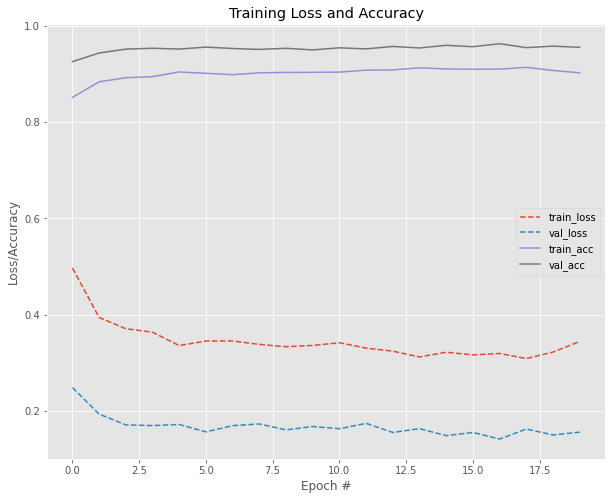

[INFO] 0.00329876848926052 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0001885152514944922 kWh
[INFO] Energy consumed for all GPU: 0.001424479359138674 kWh
[INFO] Energy consumed for all CPU: 0.0016857738786273534 kWh
[INFO] CO2 emission 0.0010490083795848453(in Kg)
[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.96      0.95      0.95      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.95      0.96       892
           6       0.97      0.97      0.97       958
           7       0.94      0.95      0.94      1028
           8       0.94      0.91      0.93       974
           9       0.93      0.93      0.93      1009

    accuracy        

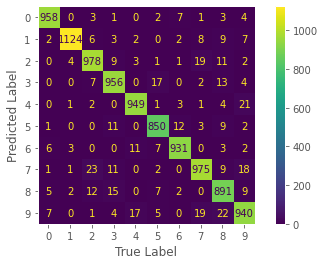

22-10-2022 13:52:29 Uploading figures
22-10-2022 13:52:29 Validation Evaluation metrics
22-10-2022 13:52:29 Validation Accuracy: 0.9552
22-10-2022 13:52:29 Validation Precision: 0.9551728362600957
22-10-2022 13:52:29 Validation Recall: 0.9552
22-10-2022 13:52:29 Validation F1: 0.9551378256335594


accuracy,▁▅▆▆▇▇▆▇▇▇▇▇▇█████▇▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂
val_accuracy,▁▄▆▆▆▇▆▆▆▆▆▆▇▆▇▇█▆▇▇
val_loss,█▄▃▃▃▂▃▃▂▃▂▃▂▂▁▂▁▂▂▂
Acc,0.9552
CO2_Emissions,0.00105
Count_Params,61706
Energy_CPU,0.00169
Energy_Consumed,0.0033
Energy_GPU,0.00142


wandb: Agent Starting Run: 2ycxsvix with config:
wandb: 	activation: tanh
wandb: 	batch_normalization: [1, 0]
wandb: 	drop1: 0
wandb: 	drop2: 0.15
wandb: 	drop3: 0.5
wandb: 	drop4: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        24        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0

22-10-2022 13:52:51 [INFO] compiling model...
22-10-2022 13:52:51 [INFO] training network...


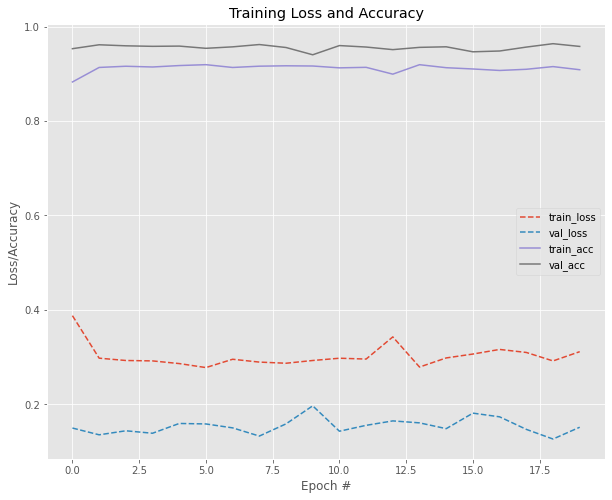

[INFO] 0.0032783973660014906 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.000188569839381593 kWh
[INFO] Energy consumed for all GPU: 0.0014034919508737324 kWh
[INFO] Energy consumed for all CPU: 0.0016863355757461655 kWh
[INFO] CO2 emission 0.0010425303623884741(in Kg)
[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.96      0.94      0.95      1032
           3       0.96      0.95      0.96      1010
           4       0.96      0.95      0.96       982
           5       0.97      0.96      0.96       892
           6       0.95      0.98      0.96       958
           7       0.94      0.96      0.95      1028
           8       0.97      0.94      0.95       974
           9       0.94      0.94      0.94      1009

    accuracy      

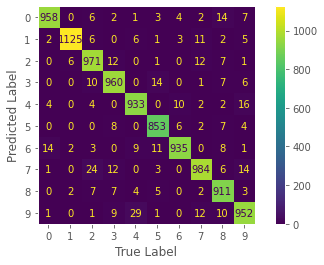

22-10-2022 13:55:15 Uploading figures
22-10-2022 13:55:15 Validation Evaluation metrics
22-10-2022 13:55:15 Validation Accuracy: 0.9582
22-10-2022 13:55:15 Validation Precision: 0.9582826746458931
22-10-2022 13:55:15 Validation Recall: 0.9582
22-10-2022 13:55:15 Validation F1: 0.9581487942342514


accuracy,▁▇▇▇██▇▇█▇▇▇▄█▇▆▆▆▇▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▂▁▂▂▂▂▂▂▅▁▂▃▃▃▂▃
val_accuracy,▅▇▇▆▆▅▆▇▆▁▇▆▄▆▆▃▃▆█▆
val_loss,▃▂▃▂▄▄▃▂▄█▃▄▅▄▃▆▆▃▁▃
Acc,0.9582
CO2_Emissions,0.00104
Count_Params,61730
Energy_CPU,0.00169
Energy_Consumed,0.00328
Energy_GPU,0.0014


wandb: Agent Starting Run: vunwi7di with config:
wandb: 	activation: tanh
wandb: 	batch_normalization: [1, 0]
wandb: 	drop1: 0.2
wandb: 	drop2: 0.15
wandb: 	drop3: 0.4
wandb: 	drop4: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        24        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0

22-10-2022 13:55:36 [INFO] compiling model...
22-10-2022 13:55:36 [INFO] training network...


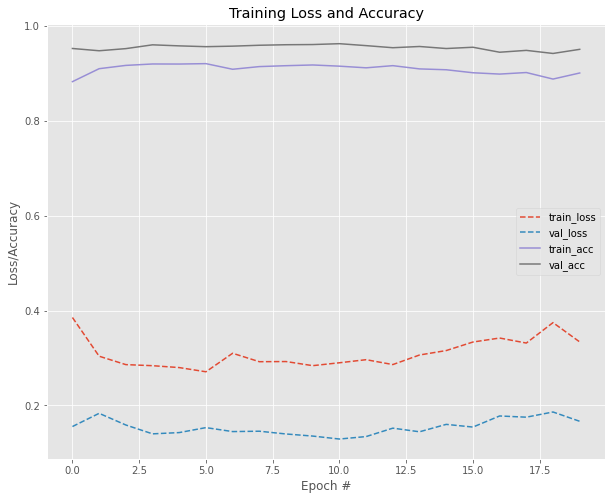

[INFO] 0.0029661381750014115 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00016862745032595531 kWh
[INFO] Energy consumed for all GPU: 0.0012895681537639433 kWh
[INFO] Energy consumed for all CPU: 0.0015079425709115136 kWh
[INFO] CO2 emission 0.0009432319396504489(in Kg)
[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.99      0.97      1135
           2       0.96      0.94      0.95      1032
           3       0.96      0.95      0.95      1010
           4       0.95      0.95      0.95       982
           5       0.96      0.95      0.95       892
           6       0.95      0.98      0.97       958
           7       0.95      0.96      0.95      1028
           8       0.94      0.90      0.92       974
           9       0.93      0.92      0.93      1009

    accuracy    

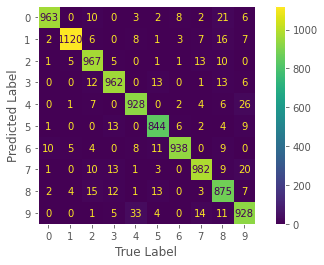

22-10-2022 13:57:46 Uploading figures
22-10-2022 13:57:46 Validation Evaluation metrics
22-10-2022 13:57:46 Validation Accuracy: 0.9507
22-10-2022 13:57:46 Validation Precision: 0.95066540039383
22-10-2022 13:57:46 Validation Recall: 0.9507
22-10-2022 13:57:46 Validation F1: 0.9505338569048899


accuracy,▁▆▇███▆▇▇▇▇▆▇▆▆▄▄▅▂▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▁▃▂▂▂▂▃▂▃▄▅▅▅▇▅
val_accuracy,▅▃▄▇▆▆▆▇▇▇█▇▅▆▅▅▂▃▁▄
val_loss,▄█▅▂▃▄▃▃▂▂▁▂▄▃▅▄▇▇█▆
Acc,0.9507
CO2_Emissions,0.00094
Count_Params,61730
Energy_CPU,0.00151
Energy_Consumed,0.00297
Energy_GPU,0.00129


wandb: Agent Starting Run: cf5xh31j with config:
wandb: 	activation: tanh
wandb: 	batch_normalization: [0, 1]
wandb: 	drop1: 0
wandb: 	drop2: 0
wandb: 	drop3: 0
wandb: 	drop4: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization (BatchN  (None, 10, 10, 16)       64        
 ormalization)                                                   
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0

22-10-2022 13:58:09 [INFO] compiling model...
22-10-2022 13:58:09 [INFO] training network...


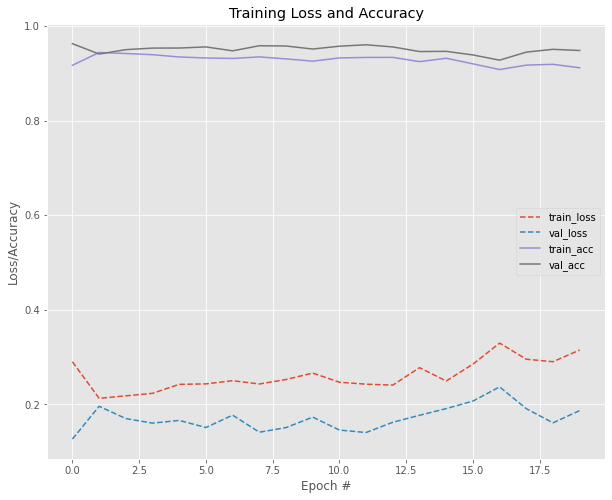

[INFO] 0.0028146091455397244 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0001609241425688962 kWh
[INFO] Energy consumed for all GPU: 0.0012145827751505374 kWh
[INFO] Energy consumed for all CPU: 0.0014391022278202905 kWh
[INFO] CO2 emission 0.0008950457082816324(in Kg)
[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.96      0.97      0.97      1135
           2       0.94      0.96      0.95      1032
           3       0.94      0.94      0.94      1010
           4       0.95      0.96      0.96       982
           5       0.93      0.94      0.94       892
           6       0.96      0.96      0.96       958
           7       0.95      0.94      0.95      1028
           8       0.93      0.92      0.92       974
           9       0.95      0.91      0.93      1009

    accuracy     

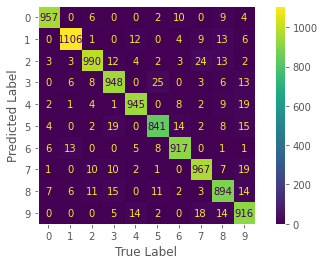

22-10-2022 14:00:12 Uploading figures
22-10-2022 14:00:12 Validation Evaluation metrics
22-10-2022 14:00:12 Validation Accuracy: 0.9481
22-10-2022 14:00:12 Validation Precision: 0.9480886142444639
22-10-2022 14:00:12 Validation Recall: 0.9481
22-10-2022 14:00:12 Validation F1: 0.9480228874343326


accuracy,▃██▇▆▆▆▆▅▄▆▆▆▄▆▃▁▃▃▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▆▁▁▂▃▃▃▃▃▄▃▃▃▅▃▅█▆▆▇
val_accuracy,█▄▅▆▆▇▅▇▇▆▇█▇▅▅▃▁▄▆▅
val_loss,▁▅▄▃▃▃▄▂▃▄▂▂▃▄▅▆█▅▃▅
Acc,0.9481
CO2_Emissions,0.0009
Count_Params,61770
Energy_CPU,0.00144
Energy_Consumed,0.00281
Energy_GPU,0.00121


wandb: Agent Starting Run: w5v4uq4j with config:
wandb: 	activation: tanh
wandb: 	batch_normalization: [0, 1]
wandb: 	drop1: 0.1
wandb: 	drop2: 0.25
wandb: 	drop3: 0
wandb: 	drop4: 0.4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization (BatchN  (None, 10, 10, 16)       64        
 ormalization)                                                   
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0

22-10-2022 14:00:32 [INFO] compiling model...
22-10-2022 14:00:32 [INFO] training network...


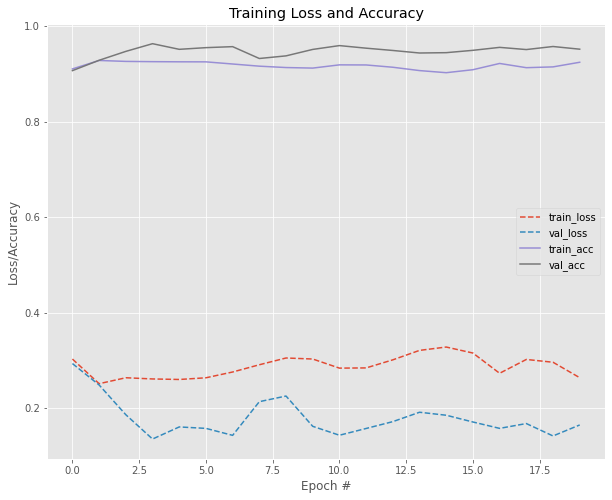

[INFO] 0.0028818289228167335 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00016391151757705834 kWh
[INFO] Energy consumed for all GPU: 0.0012520444091875685 kWh
[INFO] Energy consumed for all CPU: 0.0014658729960521063 kWh
[INFO] CO2 emission 0.0009164215974557212(in Kg)
[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       980
           1       0.99      0.97      0.98      1135
           2       0.94      0.97      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.92      0.96      0.94       982
           5       0.90      0.97      0.93       892
           6       0.96      0.96      0.96       958
           7       0.97      0.94      0.95      1028
           8       0.95      0.94      0.94       974
           9       0.96      0.88      0.92      1009

    accuracy    

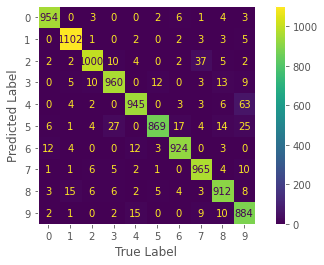

22-10-2022 14:02:38 Uploading figures
22-10-2022 14:02:38 Validation Evaluation metrics
22-10-2022 14:02:38 Validation Accuracy: 0.9515
22-10-2022 14:02:38 Validation Precision: 0.9522553911321929
22-10-2022 14:02:38 Validation Recall: 0.9515
22-10-2022 14:02:38 Validation F1: 0.9514548668725814


accuracy,▃█▇▇▇▇▆▅▄▄▅▅▄▂▁▃▆▄▄▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▆▁▂▂▂▂▃▅▆▆▄▄▆▇█▇▃▆▅▂
val_accuracy,▁▄▆█▇▇▇▄▅▇█▇▆▆▆▆▇▆▇▇
val_loss,█▆▃▁▂▂▁▄▅▂▁▂▃▃▃▃▂▂▁▂
Acc,0.9515
CO2_Emissions,0.00092
Count_Params,61770
Energy_CPU,0.00147
Energy_Consumed,0.00288
Energy_GPU,0.00125


In [ ]:
wandb.agent(sweep_id, treino, count=10)

In [ ]:
run.finish()